In [1]:
from IPython.display import Image
from IPython.core.display import HTML 


## Configuración del entorno

In [2]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [3]:
def dibuja_dataset(X, y):  
    from matplotlib.colors import ListedColormap
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    plt.scatter(X[:,0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')

## Dataset

Como en otras ocasiones vamos a generar un dataset ficticio:

In [4]:
from sklearn.datasets import make_moons
dataset_X, dataset_y = make_moons(noise=0.7, random_state=10)

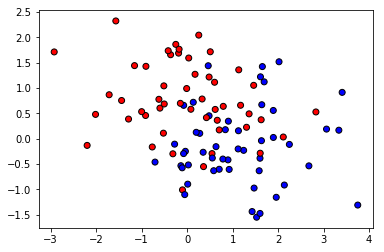

In [5]:
dibuja_dataset(dataset_X, dataset_y)

In [10]:
# Dividimos en conjunto de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, test_size=.3, random_state=54)

# Modelo solo Entrenamiento y Test

<img src="dib1.png"  width="600">

In [11]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=42)
clf.fit(X_train, y_train) 

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
clf.score(X_train, y_train)

0.81428571428571428

In [13]:
clf.score(X_test, y_test)

0.73333333333333328

# Modelo solo Cross-Validation, variante 1

<img src="dib2.png"  width="300">

In [14]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# Probamos la combinación de parámetros 
for kernel in ['linear', 'rbf']:
    for C in [0.01, 10 ]:
        scores = cross_val_score(SVC(kernel=kernel, C=C), dataset_X, dataset_y, cv=5)
        print("Kernel: %8s\tC: %0.3f\tMean Accuracy: %.3f\tAccuracy CV: %s" % (kernel, C, np.mean(scores), scores))

Kernel:   linear	C: 0.010	Mean Accuracy: 0.760	Accuracy CV: [ 0.7  0.7  0.9  0.8  0.7]
Kernel:   linear	C: 10.000	Mean Accuracy: 0.780	Accuracy CV: [ 0.7  0.8  0.8  0.9  0.7]
Kernel:      rbf	C: 0.010	Mean Accuracy: 0.770	Accuracy CV: [ 0.7   0.8   0.85  0.8   0.7 ]
Kernel:      rbf	C: 10.000	Mean Accuracy: 0.800	Accuracy CV: [ 0.7   0.85  0.8   0.85  0.8 ]


# Modelo solo Cross-Validation, variante 2

<img src="dib2.png"  width="300">

In [15]:
from sklearn.model_selection import GridSearchCV

params_grid = {
    'C': [0.001, 1, 10], 
    'kernel': ['linear', 'rbf']
}

grid_svm = GridSearchCV(
    SVC(), 
    param_grid=params_grid, 
    n_jobs=4, 
    scoring='accuracy',
    cv = 3
)

In [16]:
grid_svm.fit(dataset_X, dataset_y)

GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'C': [0.001, 1, 10], 'kernel': ['linear', 'rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [17]:
print(grid_svm.best_params_)

{'C': 0.001, 'kernel': 'rbf'}


In [18]:
print(grid_svm.best_score_) # roc_auc

0.77


# Modelo  Cross-Validation y conjunto de Test adicional

<img src="dib4.png"  width="300">

In [19]:
from sklearn.model_selection import GridSearchCV

# Ajustamos los hiperparámetros a analizar
params_grid = {
    'C': [0.001, 1, 10], 
    'kernel': ['linear', 'rbf']
}

grid_svm = GridSearchCV(SVC(), param_grid=params_grid, scoring="accuracy")

# Entrenamos el modelo sobre X_train
grid_svm.fit(X_train, y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 1, 10], 'kernel': ['linear', 'rbf']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [20]:
# Lo evaluamos, datos test
grid_svm.best_params_

{'C': 1, 'kernel': 'rbf'}

In [21]:
grid_svm.best_score_

0.75714285714285712

In [22]:
# Lo evaluamos, datos test
grid_svm.score(X_test, y_test)

0.73333333333333328

# Modelo  conjunto de validación y conjunto de test adicional

<img src="dib5.png"  width="600">

In [23]:
X_train_total, X_test, y_train_total, y_test = train_test_split(dataset_X, dataset_y, test_size=.2, random_state=54)
X_train, X_val, y_train, y_val = train_test_split(X_train_total, y_train_total, test_size=.2, random_state=41) # usamos el X_train_total para hacer una partición adicional
# ahora tenemos tres conjuntos de datos: train, validacion y test.

In [24]:
# Probamos la combinación de parámetros sobre train y val
for kernel in ['linear', 'rbf']:
    for C in [0.01, 10 ]:
        clasificador = SVC(kernel=kernel, C=C).fit(X_train, y_train)
        scores = clasificador.score(X_val, y_val)
        print("Kernel: %8s\tC: %0.3f\tAccuracy: %.3f" % (kernel, C, scores))

Kernel:   linear	C: 0.010	Accuracy: 0.688
Kernel:   linear	C: 10.000	Accuracy: 0.688
Kernel:      rbf	C: 0.010	Accuracy: 0.500
Kernel:      rbf	C: 10.000	Accuracy: 0.875


In [25]:
# Una vez sabemos cuales son los mejores parametros usamos todo el conjunto de entrenamiento para entrenar de nuevo
# el modelo y sacamos el resultado sobre el conjunto de test.
clasificador_elegido = SVC(kernel='rbf', C=10.).fit(X_train_total, y_train_total)
clasificador_elegido.score(X_test, y_test)

0.75

## Otra forma ya vista en un worksheet anterior

### Cuando hacemos muchas comparaciones deberiamos realizar las busquedas del hiperparametro optimo con un conjunto de datos de entrenamiento y validacion, distintos al conjunto de test

### Esto se puede hacer de varias maneras, a continuacion veremos dos formas:

### 1. Usando validacion cruzada para realizar las validaciones en la busqueda del valor optimo de los hiperparametros

In [23]:
from sklearn.neighbors import KNeighborsClassifier

In [24]:
X_train, X_test, y_train, y_test = train_test_split(dataset_X, dataset_y, test_size=.3, random_state=42)

val_errors = []
t = list(reversed(range(1, 50, 2)))
np.random.seed(123)
for n in t:
    accuracy_cv = cross_val_score(KNeighborsClassifier(n_neighbors=n), X_train, y_train, cv=5,scoring='accuracy').mean()
    val_errors.append(1-accuracy_cv) # error de validacion

  

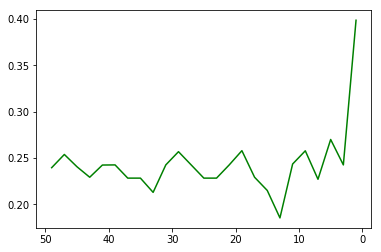

In [25]:
import matplotlib.pyplot as plt

plt.plot(t, val_errors, 'g') # verde --> error de validacion
plt.gca().invert_xaxis()
plt.show()

In [26]:
# Valor optimo
50-np.argmin(val_errors)*2

14

#### Con este valor optimo obtenemos el resultado sobre el conjunto de test

In [27]:
from sklearn.metrics import accuracy_score

knn_opt = KNeighborsClassifier(n_neighbors=14)
knn_opt.fit(X_train,y_train)
y_hat = knn_opt.predict(X_test)
print("accuracy sobre el conjunto de test final: {}".format(accuracy_score(y_test,y_hat)))

accuracy sobre el conjunto de test final: 0.8333333333333334


### 2. Usando un conjunto de validacion (diferente al de entrenamiento y test) en la busqueda del valor optimo de los hiperparametros

In [28]:
X_train_total, X_test, y_train_total, y_test = train_test_split(dataset_X, dataset_y, test_size=.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_total, y_train_total, test_size=.2, random_state=41) # usamos el X_train_total para hacer una partición adicional
# ahora tenemos tres conjuntos de datos: train, validacion y test.

val_errors = []
t = list(reversed(range(1, 50, 2)))
np.random.seed(123)
for n in t:
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    y_val_hat = knn.predict(X_val)
    val_errors.append(1-accuracy_score(y_val, y_val_hat)) # error de validacion

  

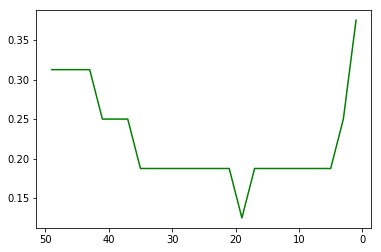

In [29]:
import matplotlib.pyplot as plt

plt.plot(t, val_errors, 'g') # verde --> error de validacion
plt.gca().invert_xaxis()
plt.show()

In [30]:
# Valor optimo
50-np.argmin(val_errors)*2

20

#### Con este valor optimo obtenemos el resultado sobre el conjunto de test

In [31]:
from sklearn.metrics import accuracy_score

knn_opt = KNeighborsClassifier(n_neighbors=20)
knn_opt.fit(X_train_total,y_train_total) #usamos todos los datos de entrenaiento para hacer un ajuste final
y_test_hat = knn_opt.predict(X_test)
print("accuracy sobre el conjunto de test final: {}".format(accuracy_score(y_test,y_test_hat)))

accuracy sobre el conjunto de test final: 0.85


#### En este caso vemos que no hay grandes diferencias, pero cuando el numero de muestras es pequeño y/o el numero de busquedas del hiperparametro es elevado, la diferencia puede ser importante.